In [39]:
pwd

'/user/vpalline'

In [40]:
!which python

/projects/academic/courses/cse546s23/vpalline/anaconda3/bin/python


In [41]:
#Importing all the required packages
import gymnasium as gym
import gym
import copy
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from operator import add
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pickle

In [42]:
#GridWorld Game - Environment Definition
grid_world = np.zeros((5,5))
grid_world_size = (5,5)
print("GridWorld Game Size:",grid_world_size[0],"x",grid_world_size[1])

#GridWorld Game - Agent(Mario) Action Set Definition
action_space = ["Up","Down","Right","Left"]
print("GridWorld Game Set of Actions:", *action_space, sep=', ')


state_space=np.array([20,15,10,5,0,21,16,11,6,1,22,17,12,7,2,23,18,13,8,3,24,19,14,9,4]).reshape(5,5)
print("GridWorld Game Set of States:"+str(state_space))


GridWorld Game Size: 5 x 5
GridWorld Game Set of Actions:, Up, Down, Right, Left
GridWorld Game Set of States:[[20 15 10  5  0]
 [21 16 11  6  1]
 [22 17 12  7  2]
 [23 18 13  8  3]
 [24 19 14  9  4]]


## **PART 1 & 2**

## **1. DETERMINISTIC ENVIRONMENT**

In [43]:
class Mario_Game_Deterministic_Environment(gym.Env):
    def __init__(self, max_timeSteps):
        #GridWorld Game - Observation space Definition( no. of rows * columns)
        self.observation_space = spaces.Discrete(25)
        #GridWorld Game - Setting the maximum no. of steps agent can take
        self.max_timeSteps = 16
        
            
    def reset(self):

        #GridWorld Game - Agent's Initial Position
        self.agent_pos = np.array([0, 4])
        #GridWorld Game - Agent's EndGoal Position
        self.end_goal_pos = np.array([2,2])

        #GridWorld Game - Positions of Gold_Chest (+ Reward)
        self.gold_chest_pos= np.array([[0,1],[1,3],[3,4],[4,1]])
        #GridWorld Game - Positions of Food (+ Reward)
        self.Food_pos = np.array([[2,3],[1,0],[4,3]])
        #GridWorld Game - Positions of devils (- Reward)
        self.devil_pos = np.array([[2,0],[0,2]])
        #GridWorld Game - Positions of dragons (- Reward)
        self.dragon_pos = np.array([[2,4],[4,0]])

        #GridWorld Game - Setting initial values for rewards, cumulative_rewards,timesteps
        self.rewards = 0      
        self.cumulative_rewards = 0
        self.timeStep = 0
        self.state = np.zeros(grid_world_size)
        self.done = False
        #print("After Resetting Agent Position:")
        #print(self.agent_pos)
        return
    
    def step(self, action):
        previous_pos = self.agent_pos.copy()
        if action == 0:
            #Action = Left
            self.agent_pos[0] -= 1
        if action == 1:
            #Action = Right
            self.agent_pos[0] += 1
        if action == 2:
            #Action = Up
            self.agent_pos[1] += 1
        if action == 3:
            #Action = Down
            self.agent_pos[1] -= 1
        
        #To ensure the Agent is within the 5x5 grid limits - clip function
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.state = np.zeros(grid_world_size)
        
        #GridWorld Game Rewards Configuration and Unconfiguration once the rewards are collected
        reward = 1
        #Reward for Previous Position
        if np.all(self.agent_pos == previous_pos):
            reward = -1
        #Reward for End Goal Position
        if (self.agent_pos == self.end_goal_pos).all():
            reward = 50
            self.done = True
            self.rewards += 1
        #Positive Reward for Gold Chest Position
        if (np.any(np.all(self.agent_pos == self.gold_chest_pos, axis=1))):
            reward = 10
            for index in range(len(self.gold_chest_pos)):
                if (self.gold_chest_pos[index]==self.agent_pos).all():
                    self.gold_chest_pos = np.delete(self.gold_chest_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Positive Reward for Food Position
        if (np.any(np.all(self.agent_pos == self.Food_pos, axis=1))):
            reward = 25
            for index in range(len(self.Food_pos)):
                if (self.Food_pos[index]==self.agent_pos).all():
                    self.Food_pos = np.delete(self.Food_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Negative Reward for Devil Position
        if (np.any(np.all(self.agent_pos == self.devil_pos, axis=1))):
            reward = -5
            for index in range(len(self.devil_pos)):
                if (self.devil_pos[index]==self.agent_pos).all():
                    self.devil_pos = np.delete(self.devil_pos, index, axis=0)
                    break
        #Negative Reward for Dragon Position
        if (np.any(np.all(self.agent_pos == self.dragon_pos, axis=1))):
            reward = -10
            for index in range(len(self.dragon_pos)):
                if (self.dragon_pos[index]==self.agent_pos).all():
                    self.dragon_pos = np.delete(self.dragon_pos, index, axis=0)
                    break 

        #Calculating the cummulative rewards until the current timestep
        self.cumulative_rewards += reward
        self.timeStep += 1

        #Checking if we reached Goal Position or reached the maximum timesteps allowed
        if not self.done:
            self.done = True if self.timeStep >= self.max_timeSteps else False

        #Storing the Agent's  Current Position and Reward , Cummulative Rewards
        info = "Current Agent Position: [" + str(self.agent_pos[0]) + "," + str(self.agent_pos[1]) + "] ; " + "Current State Reward: " + str(reward) + " ; " + "Total Cumulative Reward: " + str(self.cumulative_rewards)
        #print(info)
        return self.agent_pos,reward, self.done, info
    
    def render(self):
        #Plot size
        fig,ax = plt.subplots(figsize=(7.5,7.5),facecolor="white")
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)
        plt.grid()
        ax.set_facecolor("black")
        agent1_pos,goal1_pos = False,False
        plt.xticks([0,1,2,3,4,5])
        plt.yticks([0,1,2,3,4,5])

        if not agent1_pos:
            #For Agent's Visualization
            agent = AnnotationBbox(OffsetImage(plt.imread('agent.png'), zoom=0.2), list(map(add, self.agent_pos , [0.3, 0.4])), frameon=True)
            ax.add_artist(agent)

        if not goal1_pos:
            #For End Goal Visulaization
            goal = AnnotationBbox(OffsetImage(plt.imread('goal_pos.png'), zoom=0.087), list(map(add, self.end_goal_pos , [0.5, 0.4])), frameon=False)
            ax.add_artist(goal)

        for Food1_pos in self.Food_pos:
            #For Mushrooom Food State Visualization
            Food = AnnotationBbox(OffsetImage(plt.imread('Food.png'), zoom=0.098), list(map(add, Food1_pos, [0.68, 0.68])), frameon=False)
            ax.add_artist(Food)

        for gold1_chest_pos in self.gold_chest_pos:
            #For Gold Chest State Visulaization
            gold = AnnotationBbox(OffsetImage(plt.imread('gold_chest.png'), zoom=0.175), list(map(add, gold1_chest_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(gold)

        for devil1_pos in self.devil_pos:
            #For Devil state Visualization
            devil = AnnotationBbox(OffsetImage(plt.imread('Devil.png'), zoom=0.25), list(map(add, devil1_pos, [0.72, 0.72])), frameon=False)
            ax.add_artist(devil)

        for dragon1_pos in self.dragon_pos:
            #For Dragon state Visualization
            dragon = AnnotationBbox(OffsetImage(plt.imread('Dragon.png'), zoom=0.2), list(map(add, dragon1_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(dragon)

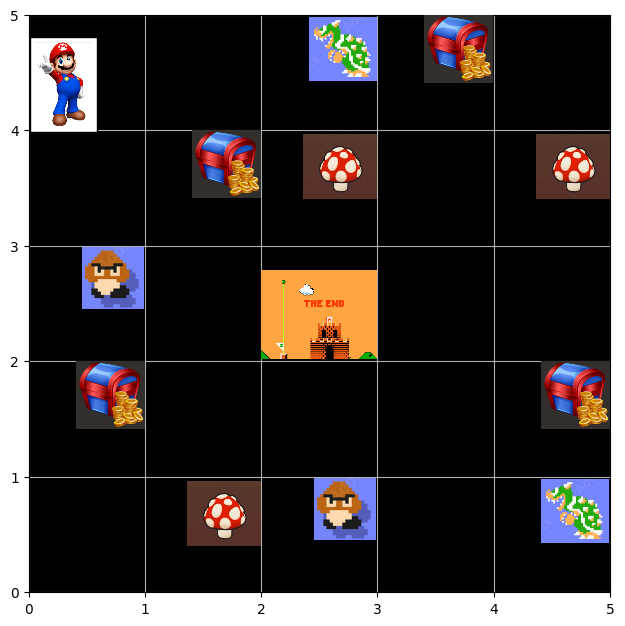

In [44]:
# Initial State Position of the Environment
env = Mario_Game_Deterministic_Environment(16) 
env.reset()
env.render()

Timestep: 1			 Performing Action: Left
Current Agent Position: [0,4] ; Current State Reward: -1 ; Total Cumulative Reward: -1
Timestep: 2			 Performing Action: Left
Current Agent Position: [0,4] ; Current State Reward: -1 ; Total Cumulative Reward: -2
Timestep: 3			 Performing Action: Down
Current Agent Position: [0,3] ; Current State Reward: 1 ; Total Cumulative Reward: -1
Timestep: 4			 Performing Action: Down
Current Agent Position: [0,2] ; Current State Reward: -5 ; Total Cumulative Reward: -6
Timestep: 5			 Performing Action: Up
Current Agent Position: [0,3] ; Current State Reward: 1 ; Total Cumulative Reward: -5
Timestep: 6			 Performing Action: Left
Current Agent Position: [0,3] ; Current State Reward: -1 ; Total Cumulative Reward: -6
Timestep: 7			 Performing Action: Down
Current Agent Position: [0,2] ; Current State Reward: 1 ; Total Cumulative Reward: -5
Timestep: 8			 Performing Action: Right
Current Agent Position: [1,2] ; Current State Reward: 1 ; Total Cumulative Reward: 

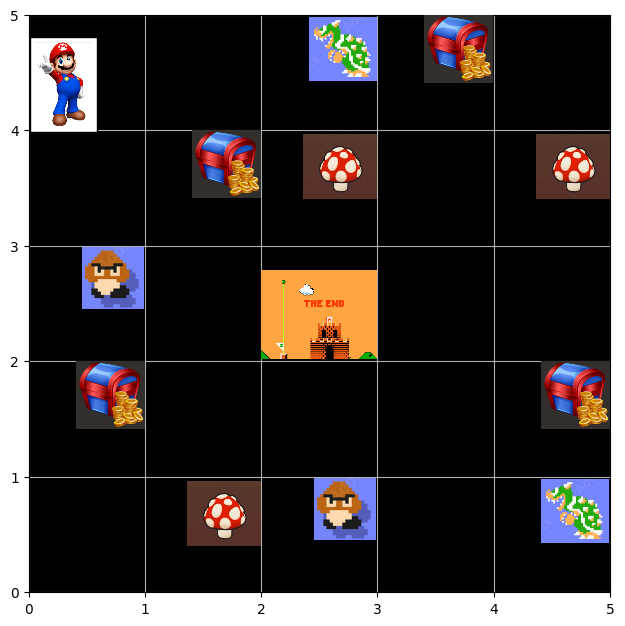

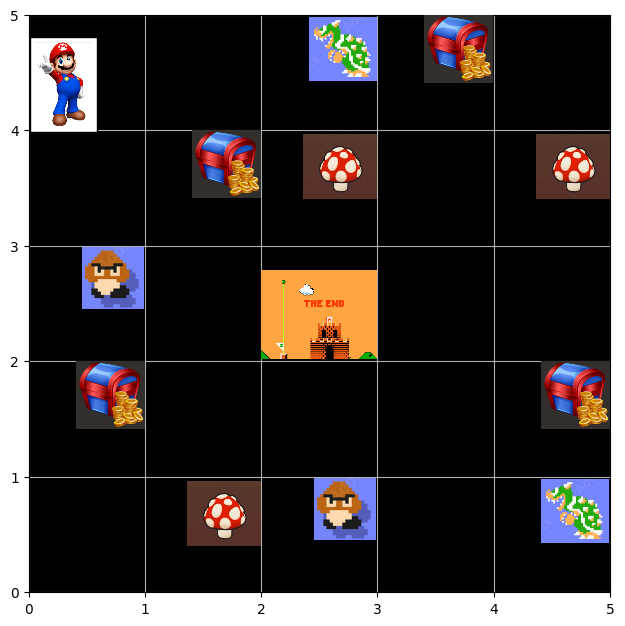

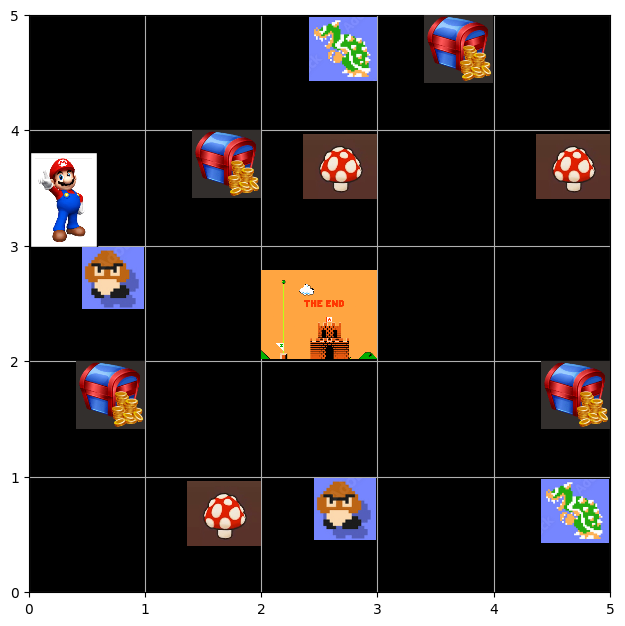

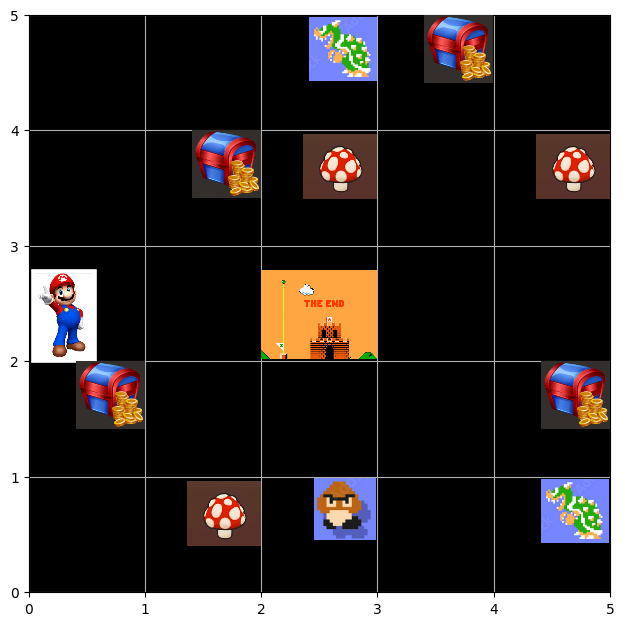

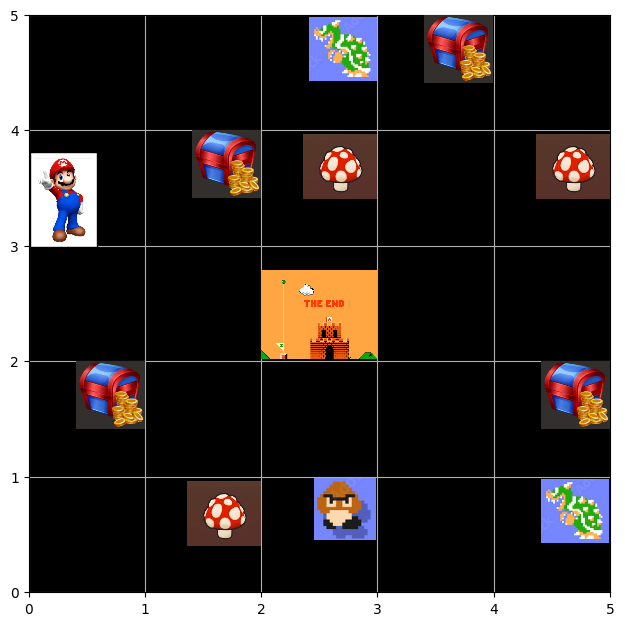

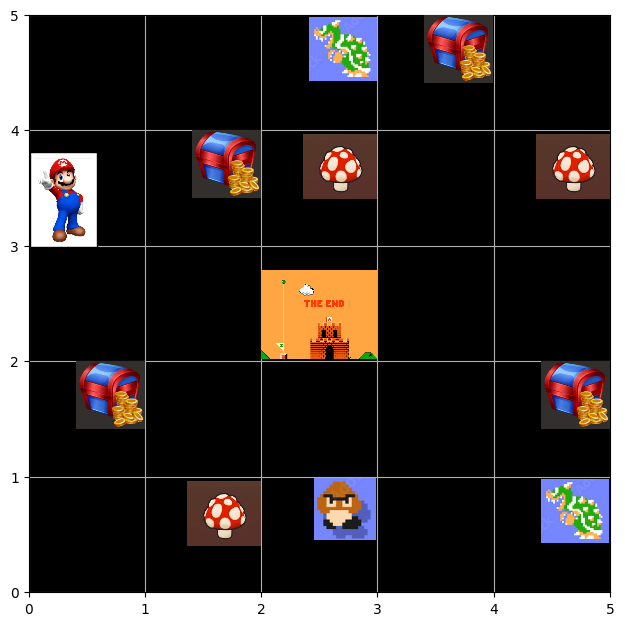

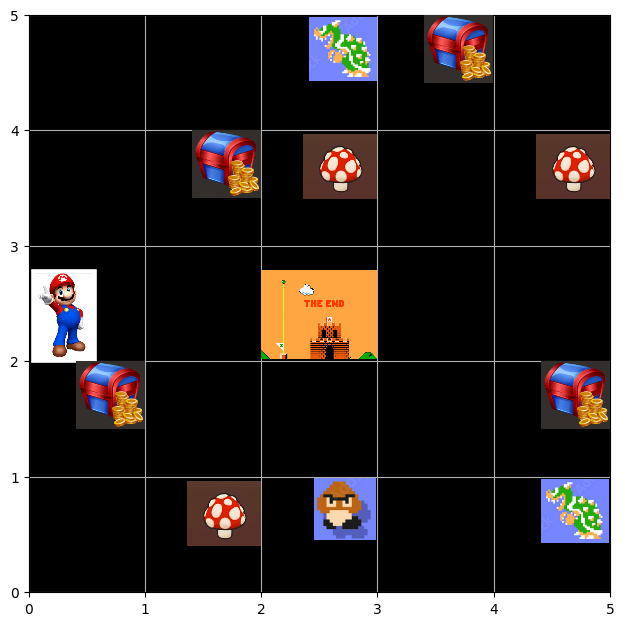

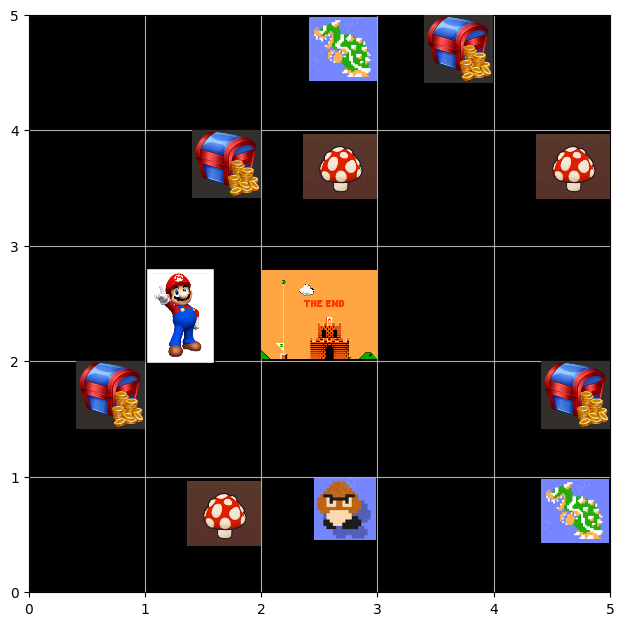

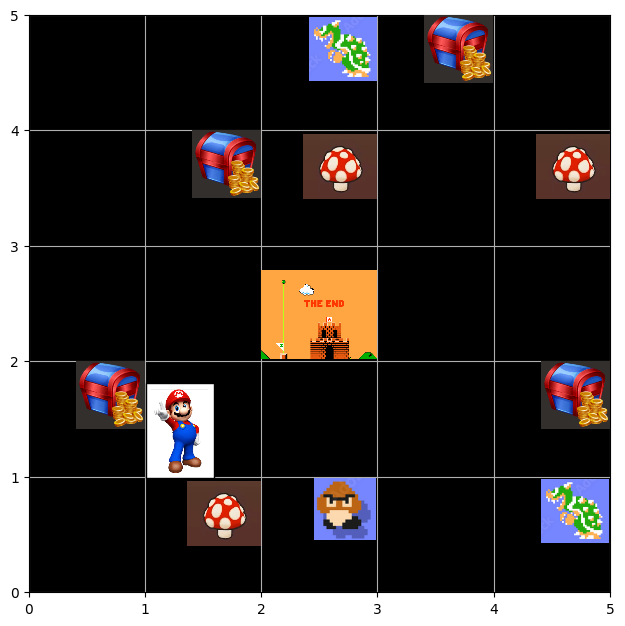

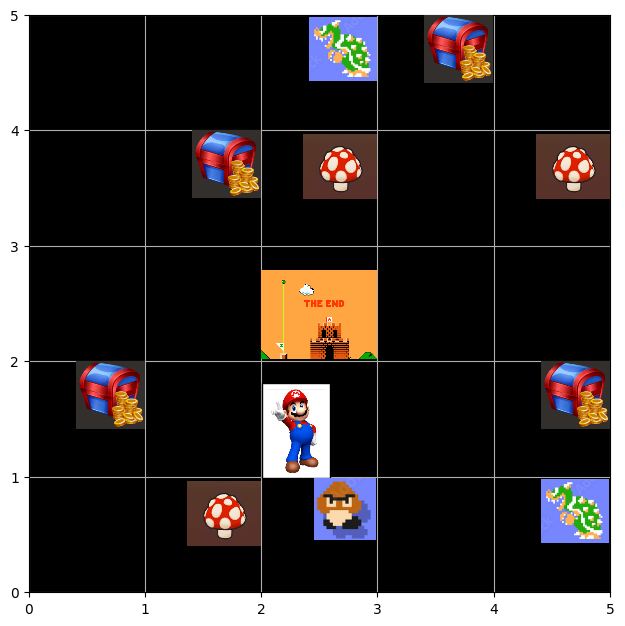

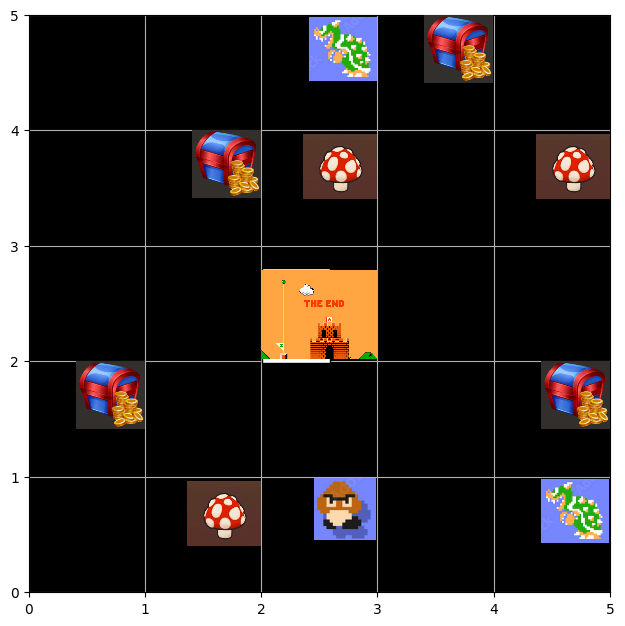

In [45]:
#Running the Mario GridWorld Game in Deterministic Environment
done = False
Actions={0:"Left",1:"Right",2:"Up",3:"Down"}
print("==================================================================================================")
while not done:
    action = random.randint(0,30)%4  #To pick a random action in range [0,3]
    pos,reward, done, info = env.step(action)
    env.render()
    print("Timestep: {}".format(env.timeStep)+"\t\t\t Performing Action: "+Actions[int(action)])
    print(info)
    print("=================================================================================================")

# **1.1 Q LEARNING - DETERMINISTIC ENVIRONMENT**

In [46]:
class Q_Learning_D():
    
    # Off-Policy TD Control
    # Approximates the optimal action-value function independent of the policy being followed.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self,state,action,reward):
        
        #Declaring metric dictionary keys
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else:    
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*np.max(self.Q_Table[updated_state,:]) - self.Q_Table[state,action]),2)

    def train(self):
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Setting up keys for dictionary
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []


        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes): #number of episodes = 1000
            j = 100                         
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:     #Random Policy - choose random action
                    action = random.randint(0,25)%4
                else:                                                 #Greedy Policy - choose optimal action
                    action = np.argmax(self.Q_Table[state,:])

                #Performing resultant action and updating Q-Table                  
                self.a_pos,reward, done, info = env.step(action)
                self.update_Q_table(state,action,reward)
              
            #Appending the key-values in metric dictionary         
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
              
    def test(self,plot):
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        if plot:
            print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            if plot:
                env.render()
                print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
                print(info)
                print("=================================================================================================")

# **1.1.1 Learning Phase - Updating Q-Table**


Q-Learning Table:

[[ 4.900e-01  6.300e+00  4.200e-01  2.960e+00]
 [ 1.250e+00 -2.010e+00  1.620e+00  1.614e+01]
 [ 1.670e+00  2.230e+00  6.700e-01  1.114e+01]
 [ 1.300e-01  2.200e-01 -2.000e-02  5.000e-01]
 [ 7.000e-02 -2.000e-02 -2.000e-02  1.950e+00]
 [ 9.700e-01  1.290e+01  8.400e-01 -1.070e+00]
 [ 2.490e+00  2.814e+01  1.600e+00  1.810e+00]
 [ 7.050e+00  1.050e+00 -2.700e-01  2.949e+01]
 [ 2.820e+00  5.290e+00  4.300e-01  4.600e-01]
 [ 9.800e-01 -6.000e-02  2.000e-02  1.500e-01]
 [-2.000e-02  1.100e-01  2.600e-01  2.490e+00]
 [-1.500e-01  1.105e+01  1.190e+00  1.300e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 6.970e+00  4.000e-02  4.000e-02  2.500e-01]
 [ 2.800e-01 -2.000e-02  7.000e-02  4.900e-01]
 [-7.000e-02  2.200e-01  9.000e-02  7.800e-01]
 [ 4.600e-01  8.000e-02  1.800e-01  1.690e+00]
 [ 3.000e-02  8.000e-02  1.000e+00  0.000e+00]
 [ 4.000e-02  2.200e-01  8.000e-02  1.200e-01]
 [ 0.000e+00 -0.000e+00  1.000e-01 -2.200e-01]
 [ 1.000e-02  3.920e+00  1.100e-01  1.70

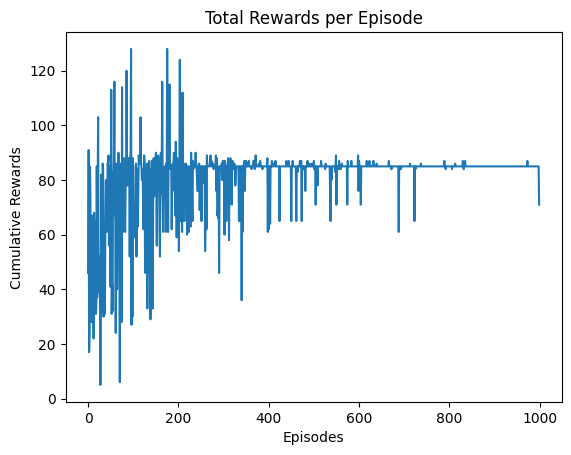

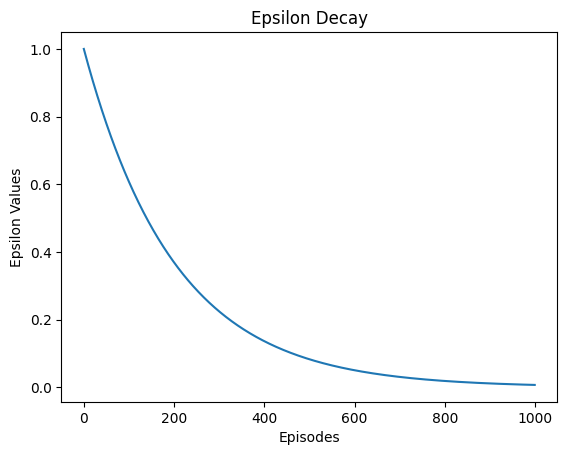

In [47]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2           # Learning-rate
hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
hyper_parameters['gamma'] = 0.8          #discount-factor
number_of_episodes = 1000                 # No of episodes
metrics = {}
ql = Q_Learning_D()
ql.train()
print("\nQ-Learning Table:\n")
print(ql.Q_Table)
with open("Deterministic_Q_Learning.pkl",'wb') as f:
    pickle.dump(ql.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()

# **1.1.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Right
Current Agent Position: [1,4] ; Current State Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2	State: 1	 Performing Action: Down
Current Agent Position: [1,3] ; Current State Reward: 10 ; Total Cumulative Reward: 11
Timestep: 3	State: 6	 Performing Action: Right
Current Agent Position: [2,3] ; Current State Reward: 25 ; Total Cumulative Reward: 36
Timestep: 4	State: 7	 Performing Action: Down
Current Agent Position: [2,2] ; Current State Reward: 50 ; Total Cumulative Reward: 86


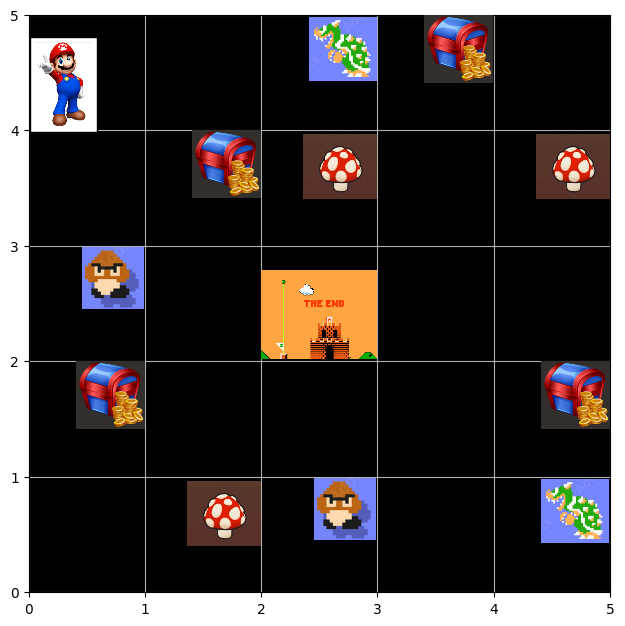

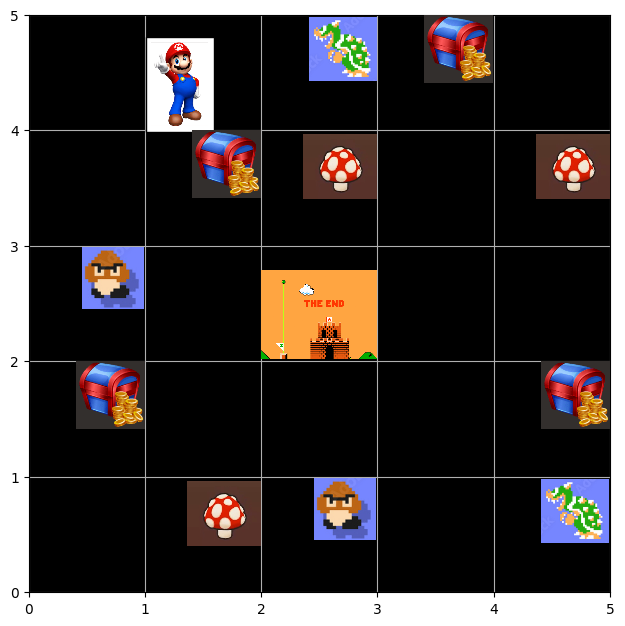

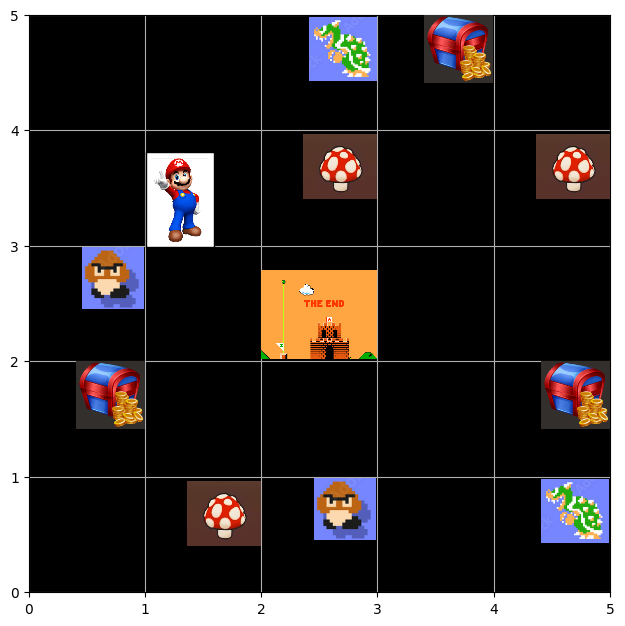

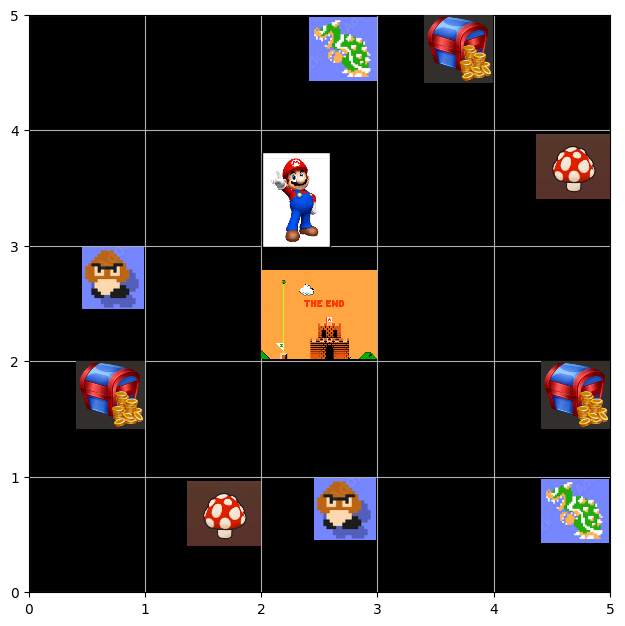

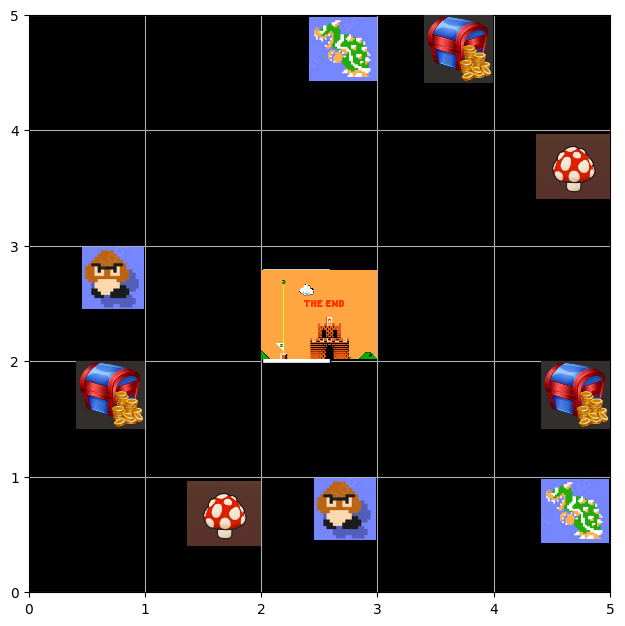

In [48]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
ql.test(plot=True)

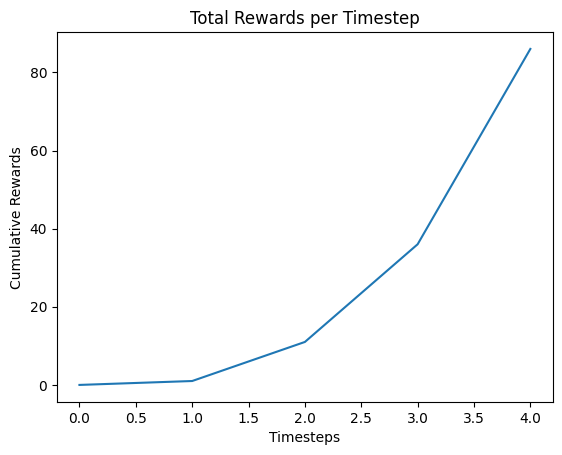

In [49]:
#Plotting Cummulative rewards as time-steps increases
metrics_ql = copy.deepcopy(metrics)
plt.plot(metrics_ql['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **1.2 SARSA - DETERMINISTIC ENVIRONMENT**

In [50]:
class SARSA_D():
    
    # On-Policy TD Control
    # Approximates the optimal action-value function based on the next state and action.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self, state, action, reward, updated_state, next_action):
        
        #Updating Q-Table using SARSA
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else: 
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*self.Q_Table[updated_state,next_action] - self.Q_Table[state,action]),2)
        
    def train(self):

        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Declaring metric dictionary keys
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []

        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes):
            j = 100
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state=int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                  action = random.randint(0,30)%4         
                else:                                                             #Greedy Policy - choose optimal action
                  action = np.argmax(self.Q_Table[state,:])                             
                self.a_pos,reward, done, info = env.step(action)
                updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                    next_action = random.randint(0,30)%4
                else:                                                             #Greedy Policy - choose optimal action
                    next_action = np.argmax(self.Q_Table[updated_state,:])
                self.update_Q_table(state, action, reward, updated_state, next_action)
                
            #Appending the key-values in metric dictionary        
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
                
    def test(self):
        
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            env.render()
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            
            print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
            print(info)
            print("=================================================================================================")

# **1.2.1 Learning Phase - Updating Q-Table**

[[-4.500e-01  8.600e-01 -3.800e-01  2.300e+00]
 [ 3.800e-01 -2.550e+00  1.300e-01  7.020e+00]
 [ 5.500e-01  2.500e+00  3.000e-02  4.910e+00]
 [ 5.000e-02  1.700e-01 -6.000e-02  6.700e-01]
 [ 3.200e-01  4.000e-02 -2.000e-02  1.650e+00]
 [ 5.000e-02  1.015e+01  5.000e-01 -1.620e+00]
 [ 1.290e+00  1.890e+01  5.900e-01  3.090e+00]
 [ 2.140e+00  4.700e-01 -1.790e+00  2.185e+01]
 [ 1.680e+00  4.550e+00  5.300e-01  3.300e-01]
 [ 1.700e-01 -9.000e-02  2.900e-01  1.000e-01]
 [-1.500e-01  1.600e-01  3.200e-01  3.220e+00]
 [-3.200e-01  2.025e+01  2.500e-01  1.600e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 5.880e+00  2.000e-02  5.000e-02  6.000e-02]
 [ 6.000e-02 -4.000e-02  9.400e-01  4.000e-02]
 [-1.100e-01  4.500e-01  1.700e-01  2.400e-01]
 [ 1.000e-01  2.900e-01  1.260e+00  3.330e+00]
 [ 1.100e-01  7.000e-02  2.100e+00 -1.700e-01]
 [ 4.000e-02  4.700e-01  2.000e-02  2.000e-02]
 [-0.000e+00  0.000e+00  2.000e-02 -2.000e-02]
 [-1.300e-01  2.520e+00  2.400e-01  3.000e-02]
 [ 1.100e-01 

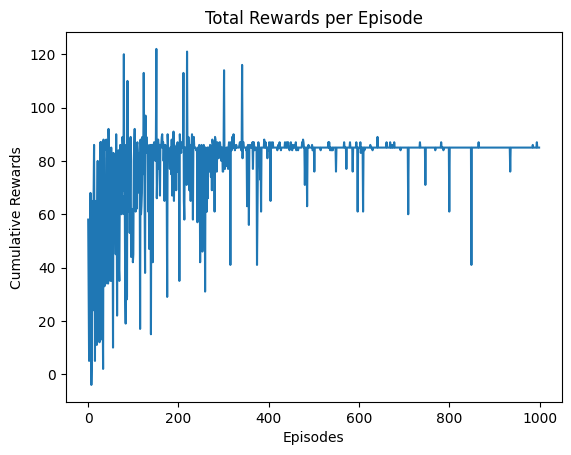

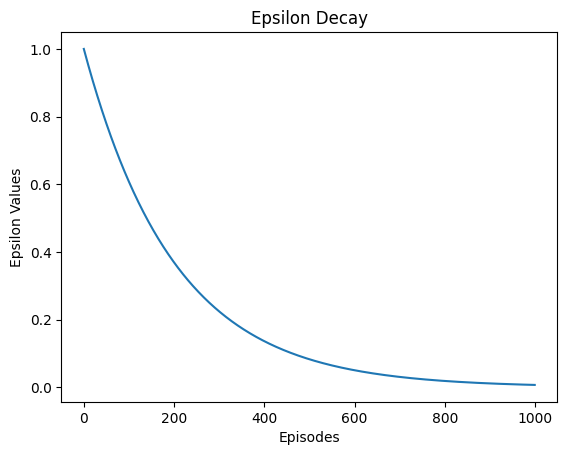

In [51]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2
hyper_parameters['max_timesteps'] = 100
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005
hyper_parameters['gamma'] = 0.8
number_of_episodes = 1000
metrics = {}
metrics['Epsilon Decay'] = []
sa = SARSA_D()
sa.train()
print(sa.Q_Table)
with open("Deterministic_SARSA.pkl",'wb') as f:
    pickle.dump(sa.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()


# **1.2.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Down
Current Agent Position: [0,3] ; Current State Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2	State: 5	 Performing Action: Right
Current Agent Position: [1,3] ; Current State Reward: 10 ; Total Cumulative Reward: 11
Timestep: 3	State: 6	 Performing Action: Right
Current Agent Position: [2,3] ; Current State Reward: 25 ; Total Cumulative Reward: 36
Timestep: 4	State: 7	 Performing Action: Down
Current Agent Position: [2,2] ; Current State Reward: 50 ; Total Cumulative Reward: 86


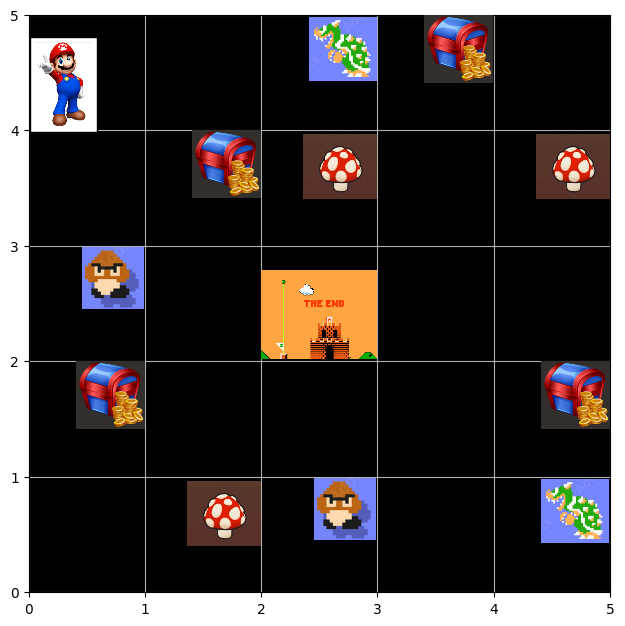

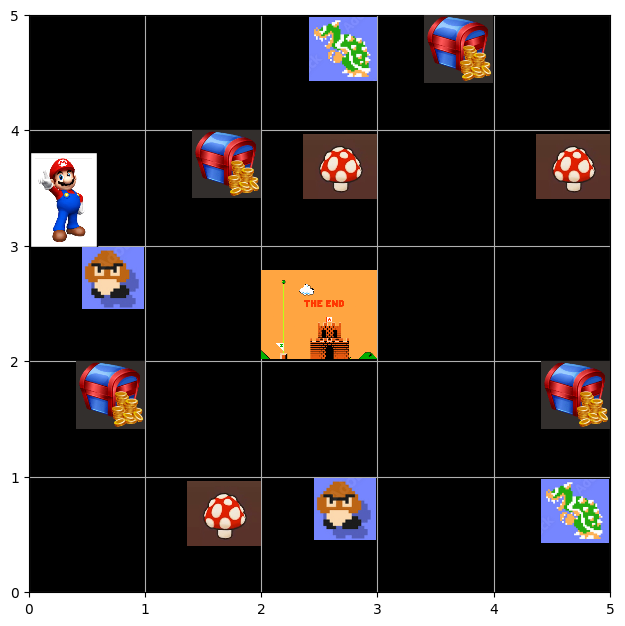

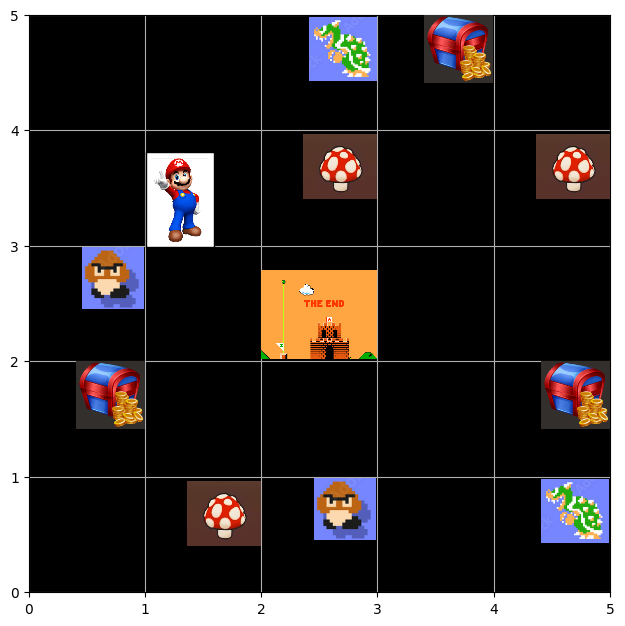

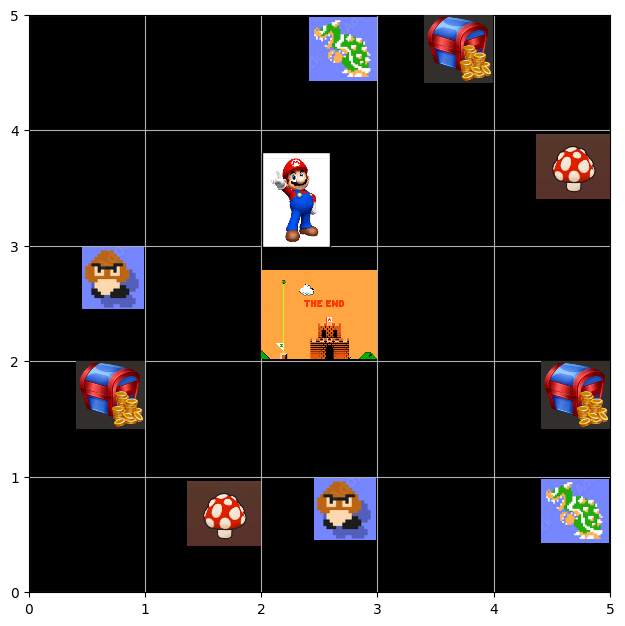

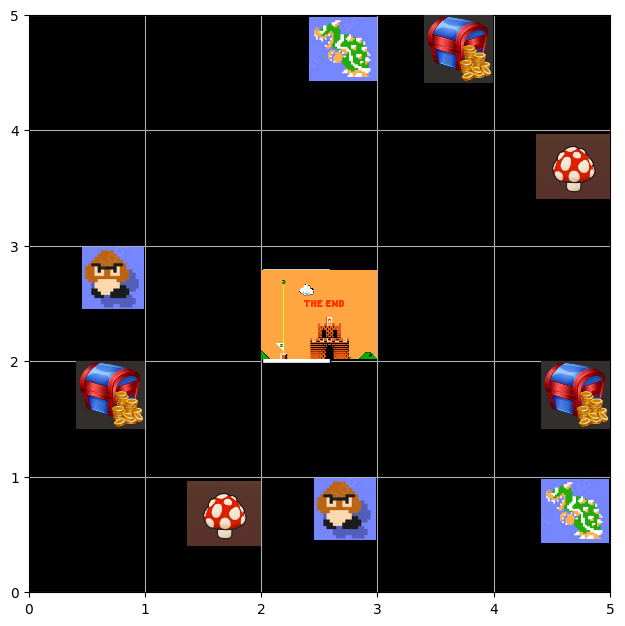

In [52]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
sa.test()

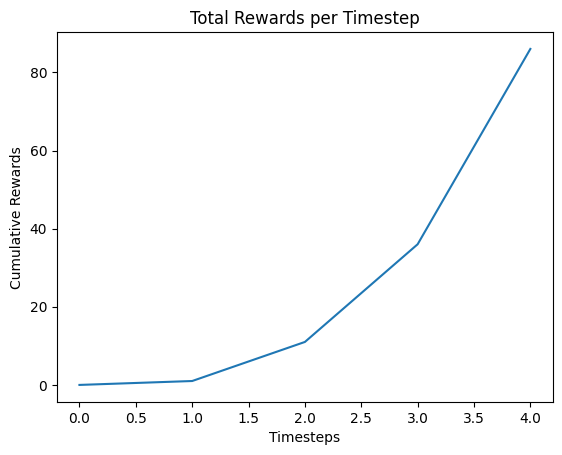

In [53]:
#Plotting Cummulative rewards as time-steps increases
metrics_sa = copy.deepcopy(metrics)
plt.plot(metrics_sa['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **1.3 Comparing Q-Learning And SARSA - DETERMINISTIC ENVIRONMENT**

Text(0.5, 0.01, 'Q-Learning : Blue, SARSA : Orange')

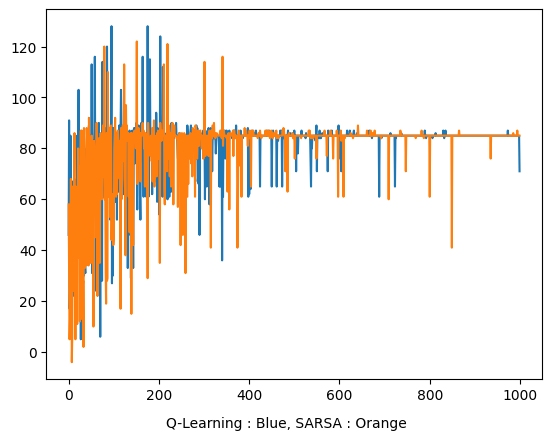

In [54]:
#Comparing the Q-learing and SARSA Cummulative Rewards
plt.plot(metrics_ql['Cumulative Rewards'],markersize=5)
plt.plot(metrics_sa['Cumulative Rewards'],markersize=5)
plt.figtext(0.5, 0.01, "Q-Learning : Blue, SARSA : Orange", horizontalalignment='center')

# **1.4 Hyperparameter Tuning - DETERMINISTIC ENVIRONMENT**

# **1.4.1 Tuning Discount Factor - 0.7 ,0.8, 0.9**


Gamma:0.7
Q-Learning Table:

[[ 6.000e-02  1.980e+00  7.000e-02  5.570e+00]
 [ 6.800e-01 -1.820e+00  8.000e-01  1.042e+01]
 [ 3.800e-01  1.030e+00  1.300e-01  8.080e+00]
 [-1.000e-02  1.400e-01 -6.000e-02  4.800e-01]
 [ 2.400e-01 -1.000e-02 -8.000e-02  1.540e+00]
 [ 2.280e+00  1.569e+01  1.110e+00 -1.400e+00]
 [ 2.280e+00  2.936e+01  1.790e+00  1.570e+00]
 [ 3.260e+00  9.100e-01 -9.000e-01  3.279e+01]
 [ 2.010e+00  4.670e+00  3.600e-01  1.300e-01]
 [ 8.500e-01  8.000e-02  1.800e-01  4.000e-02]
 [-9.000e-02  8.700e-01  5.400e-01  2.840e+00]
 [-1.900e-01  1.082e+01  1.890e+00  4.600e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 2.300e+00  1.400e-01  8.000e-02  8.000e-02]
 [ 4.000e-02  0.000e+00  2.000e-02  0.000e+00]
 [-8.000e-02  8.800e-01  1.100e-01  2.000e-02]
 [ 7.200e-01  4.800e-01  5.900e-01  3.780e+00]
 [ 4.000e-02  1.300e-01  6.410e+00  0.000e+00]
 [ 3.000e-02  2.000e-01  4.000e-02  6.000e-02]
 [ 2.000e-02  0.000e+00  0.000e+00 -2.000e-01]
 [ 2.000e-02  7.300e-01  0.000

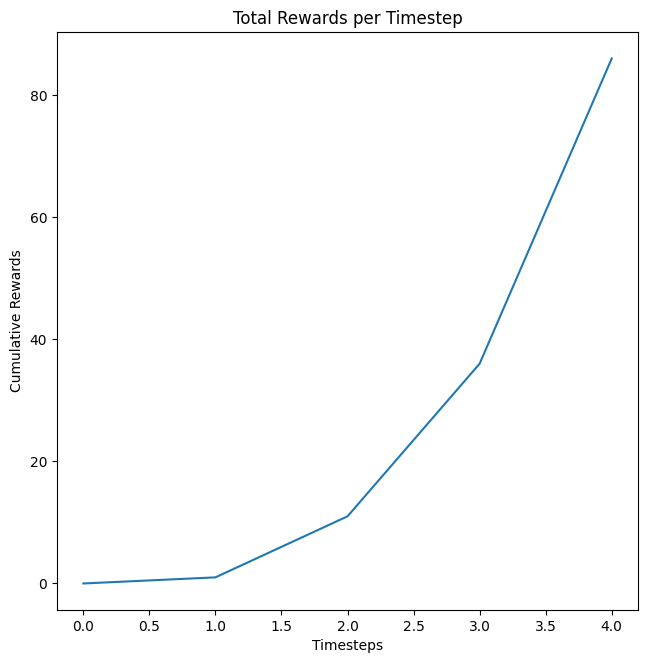


Gamma:0.8
Q-Learning Table:

[[ 1.000e-02  5.490e+00  1.100e-01  2.090e+00]
 [ 1.340e+00 -2.500e+00  1.840e+00  1.413e+01]
 [ 1.560e+00  1.440e+00  4.200e-01  1.128e+01]
 [-3.700e-01  8.000e-02 -2.000e-02  5.800e-01]
 [ 8.300e-01  2.300e-01 -2.000e-02  0.000e+00]
 [ 6.400e-01  1.021e+01  7.300e-01 -1.370e+00]
 [ 2.010e+00  2.452e+01  2.720e+00  3.000e+00]
 [ 4.150e+00  1.290e+00 -6.000e-02  2.843e+01]
 [ 3.680e+00  5.220e+00  8.400e-01  1.000e-01]
 [ 7.900e-01 -6.000e-02  1.500e-01  1.900e-01]
 [ 4.000e-02  7.700e-01  3.000e-01  3.080e+00]
 [-1.600e-01  1.456e+01  5.300e-01  4.600e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.200e-01  1.000e-01  6.000e-02  2.000e-02]
 [ 2.000e-02 -0.000e+00  6.000e-02  7.000e-01]
 [-1.900e-01  4.200e-01  1.600e-01  1.020e+00]
 [ 7.000e-01  2.800e-01  5.800e-01  3.060e+00]
 [ 1.000e-01  4.000e-02  3.040e+00  2.000e-02]
 [ 7.000e-02  2.400e-01  0.000e+00  2.000e-02]
 [ 2.000e-02  1.000e-01  8.000e-02 -4.200e-01]
 [ 3.000e-02  4.450e+00  1.700

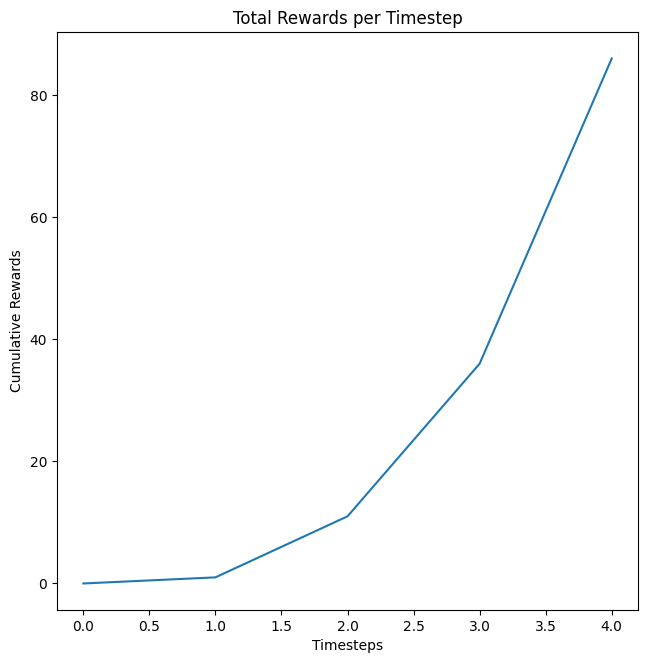


Gamma:0.9
Q-Learning Table:

[[ 9.200e-01  8.230e+00  1.060e+00  2.120e+00]
 [ 1.760e+00 -1.640e+00  1.950e+00  1.878e+01]
 [ 1.590e+00  2.520e+00  1.130e+00  1.102e+01]
 [ 2.800e-01  2.200e-01 -4.000e-02  1.230e+00]
 [ 1.500e-01  5.000e-02 -4.000e-02  1.310e+00]
 [ 1.170e+00  1.166e+01  1.130e+00 -1.020e+00]
 [ 2.200e+00  2.978e+01  3.430e+00  2.320e+00]
 [ 2.490e+00  1.390e+00 -1.100e-01  3.125e+01]
 [ 3.970e+00  7.440e+00  1.060e+00  4.400e-01]
 [ 1.570e+00 -1.000e-01  2.500e-01  9.000e-02]
 [-7.000e-02  2.200e+00  1.800e-01  6.400e-01]
 [ 4.000e-02  1.434e+01  1.380e+00  2.700e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.140e+00  6.000e-02  1.700e-01  2.600e-01]
 [ 1.700e-01 -2.000e-02  3.000e-02  7.700e-01]
 [-2.000e-02  1.900e-01  7.000e-02  0.000e+00]
 [ 1.900e-01  2.000e-02  2.300e-01  1.140e+00]
 [ 9.000e-02  0.000e+00  0.000e+00 -1.000e-02]
 [ 0.000e+00  2.000e-02  9.000e-02  4.000e-02]
 [ 2.000e-02  0.000e+00  7.000e-02 -2.200e-01]
 [ 0.000e+00  2.000e-02  0.000

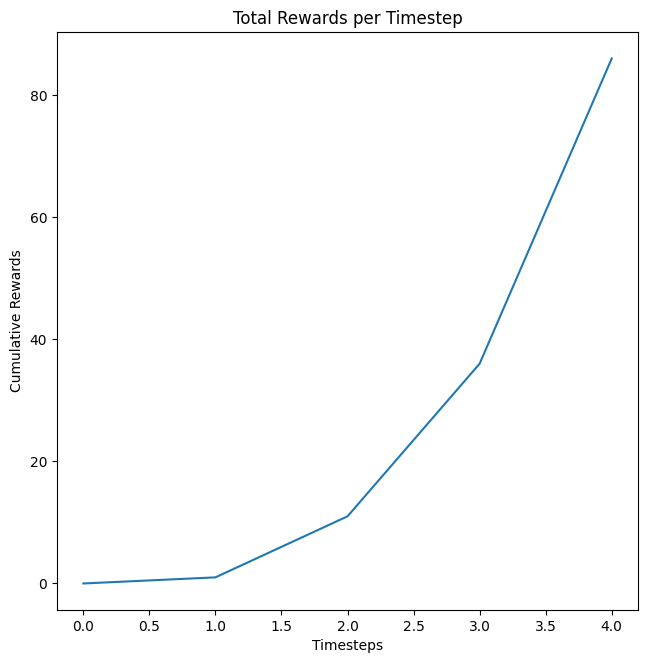

In [55]:
#Giving specific values for all the hyper parameters
for gamma in [0.7,0.8,0.9]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = 0.2           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = gamma          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_D()
    ql.train()
    print("\nGamma:"+str(gamma))
    print("Q-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()

# **1.4.2 Learning rate - 0.1 ,0.15, 0.2**


Q-Learning Table:

[[-2.500e-01  7.200e-01 -1.500e-01  1.580e+00]
 [ 3.200e-01 -2.170e+00  1.000e-01  5.070e+00]
 [ 4.200e-01  1.250e+00  1.200e-01  4.680e+00]
 [ 2.800e-01  6.000e-02 -3.000e-02  7.000e-02]
 [ 1.000e-01 -2.000e-02 -0.000e+00  1.010e+00]
 [ 9.000e-02  6.610e+00  2.800e-01 -1.060e+00]
 [ 8.900e-01  1.326e+01  8.500e-01  9.700e-01]
 [ 1.320e+00  2.700e-01 -8.100e-01  1.617e+01]
 [ 2.500e-01  2.140e+00  1.200e-01  3.900e-01]
 [ 2.000e-01 -5.000e-02  7.000e-02  3.000e-02]
 [-4.000e-02  2.900e-01  3.700e-01  1.250e+00]
 [-1.100e-01  7.080e+00  4.500e-01  1.500e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 4.460e+00  5.000e-02  3.000e-02  3.000e-02]
 [ 0.000e+00  2.000e-02  2.700e-01  1.000e-02]
 [-1.000e-02  2.000e-01  6.000e-02  7.000e-02]
 [ 4.000e-02  1.400e-01  2.500e-01  1.570e+00]
 [ 4.000e-02  1.000e-02  2.030e+00 -5.000e-02]
 [ 1.000e-02  1.000e-02  5.000e-02  3.000e-02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-8.000e-02  8.500e-01  2.000e-02 -2.00

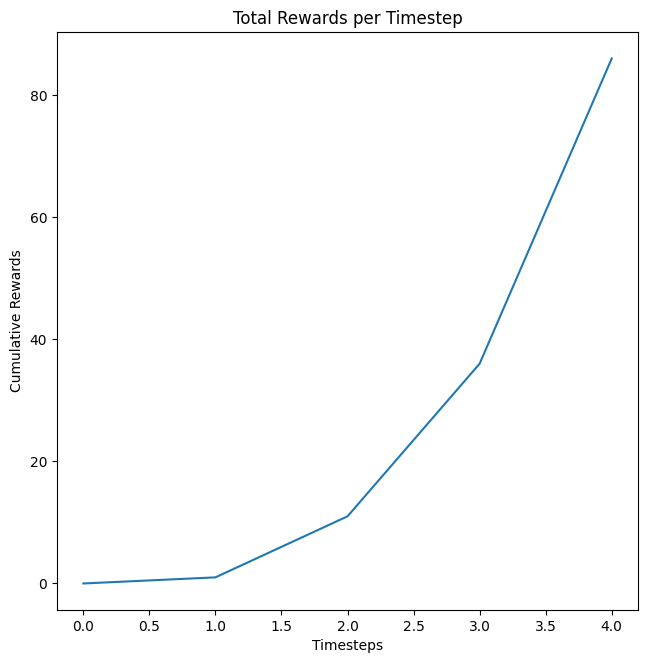


Q-Learning Table:

[[-1.400e-01  1.570e+00 -7.000e-02  3.400e+00]
 [ 5.700e-01 -1.650e+00  3.800e-01  8.010e+00]
 [ 5.700e-01  1.570e+00  3.400e-01  6.610e+00]
 [ 1.500e-01  1.300e-01 -8.000e-02  2.400e-01]
 [ 3.000e-02 -1.000e-02 -2.000e-02  1.180e+00]
 [ 5.500e-01  1.021e+01  7.000e-01 -1.270e+00]
 [ 1.480e+00  2.137e+01  1.290e+00  1.590e+00]
 [ 2.180e+00  4.300e-01 -3.700e-01  2.528e+01]
 [ 1.930e+00  2.540e+00  6.700e-01  3.500e-01]
 [ 1.400e-01 -2.000e-02  4.000e-02  1.200e-01]
 [-5.000e-02  8.600e-01  5.900e-01  2.590e+00]
 [ 1.000e-02  1.092e+01  8.900e-01  1.600e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 4.810e+00  2.000e-02  2.000e-02  2.000e-02]
 [ 1.500e-01 -0.000e+00  2.000e-02  4.000e-02]
 [-6.000e-02  2.700e-01  1.500e-01  8.100e-01]
 [ 3.600e-01  4.000e-02  4.300e-01  1.650e+00]
 [ 1.200e-01  1.000e-02  9.000e-02  0.000e+00]
 [ 2.000e-02  2.000e-02  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 -2.000e-02]
 [ 3.000e-02  4.060e+00  2.500e-01  2.00

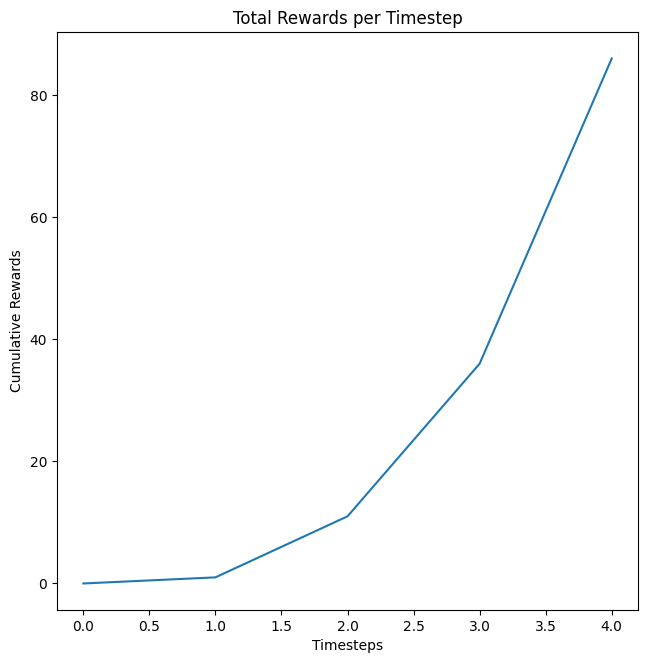


Q-Learning Table:

[[ 2.400e-01  2.000e+00  1.800e-01  5.220e+00]
 [ 1.000e+00 -2.690e+00  4.800e-01  8.070e+00]
 [ 6.400e-01  1.770e+00  1.900e-01  7.890e+00]
 [-1.000e-02  1.000e-01 -3.000e-02  4.800e-01]
 [ 6.000e-02 -1.000e-02 -1.000e-02  5.600e-01]
 [ 1.430e+00  1.280e+01  1.020e+00 -1.190e+00]
 [ 2.110e+00  2.264e+01  1.320e+00  4.890e+00]
 [ 4.230e+00  6.600e-01 -3.600e-01  2.829e+01]
 [ 5.150e+00  1.040e+00  5.700e-01  1.900e-01]
 [ 3.000e-02 -2.000e-02  6.000e-02  1.700e-01]
 [-5.000e-02  1.720e+00  3.900e-01  3.500e+00]
 [-6.900e-01  1.984e+01  5.800e-01  2.700e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 2.940e+00  5.000e-02  0.000e+00  2.000e-02]
 [ 1.000e-02  0.000e+00  9.900e-01  4.000e-01]
 [-9.000e-02  6.600e-01  1.200e-01  2.700e-01]
 [ 4.200e-01  6.000e-01  1.170e+00  3.690e+00]
 [ 1.800e-01  6.000e-02  5.790e+00  0.000e+00]
 [ 3.000e-02  4.000e-02  2.000e-02  4.000e-02]
 [ 6.000e-02  0.000e+00  2.000e-02  0.000e+00]
 [-2.000e-02  2.840e+00  8.000e-02  4.00

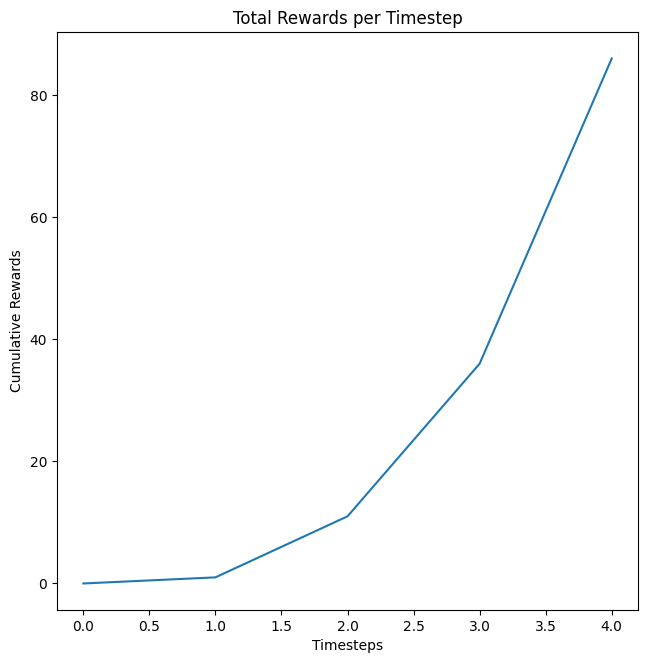

In [56]:
#Giving specific values for all the hyper parameters
for alpha in [0.1,0.15,0.2]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = alpha           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = 0.8          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_D()
    ql.train()
    print("\nQ-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()